In [22]:
import pandas as pd
import numpy as np
import os
import sqlite3
import math
from constant_values import get_passing_stat_ids, get_rushing_stat_ids, get_receiving_stat_ids, get_general_stat_ids, id_2_col, operation_2_str, year_2_idx
from scipy import stats
from matplotlib import pyplot as plt
import csv
import time
from itertools import chain

In [23]:
# ==== Output Files =====
CURRENT_FILE_DIR = 'os.path.dirname(os.path.realpath(__file__))'
DATA_DIR = '../../data'
DATABASE_FILENAME = 'nfl_road_statistics.db'
DATABASE_PATH = os.path.join(DATA_DIR, 'raw', DATABASE_FILENAME)
conn = sqlite3.connect(DATABASE_PATH)
print('OPENED CONNECTION')

OPENED CONNECTION


In [24]:
# ==== Constants =====
STAT_KEYS = ['home_mean', 'road_mean', 'home_std', 'road_std', 'home_count', 'road_count', 't_stat', 'p_val', 'cohen', 'my_t', 'difference', 'pct_difference', 'stat_type']
passing_lower_ids = get_passing_stat_ids()
rushing_lower_ids = get_rushing_stat_ids()
receiving_lower_ids = get_receiving_stat_ids()
general_lower_ids = get_general_stat_ids()
lower_id_2_sql = id_2_col()

In [25]:
# ==== Query QB Statistics =====
def get_sql_statement(key_value_dict, data_type):
	table = 'passing_statistics'
	if data_type == 'rushing':
		table = 'rushing_statistics'
	elif data_type == 'receiving':
		table = 'receiving_statistics'

	statement = '''SELECT * FROM %s''' % table
	if len(key_value_dict) > 0:
		statement += ' WHERE'
		for key in key_value_dict:
			if type(key_value_dict[key]['value']) == str:
				statement += ' %s %s %s AND' % (key, str(key_value_dict[key]['operation']), "'" + str(key_value_dict[key]['value']) + "'")
			else:
				statement += ' %s %s %s AND' % (key, str(key_value_dict[key]['operation']), str(key_value_dict[key]['value']))
		statement = statement[:-4]

	return statement + ';'

In [52]:
# ==== Load Games From SQL
def map_nan_to_val(new_val, values, stat_id):
    new_vals = values[:]
    for i in range(len(values)):
        if str(values[i]) == 'nan':
            new_vals[i] = int(new_val)
    return new_vals
            

def get_road_games(key_value_dict, data_type):
    key_value_dict['GAME_LOCATION'] = {
        'value': '@',
        'operation': '='
    }

    statement = get_sql_statement(key_value_dict, data_type)

    road_games = pd.read_sql_query(statement, conn)
    for col in road_games.columns:
        map_nan_to_val(0, road_games[col], col)
    return road_games

def get_home_games(key_value_dict, data_type):
    key_value_dict['GAME_LOCATION'] = {
        'value': '',
        'operation': '='
    }
    statement = get_sql_statement(key_value_dict, data_type)

    home_games = pd.read_sql_query(statement, conn)
    for col in home_games.columns:
        home_games[col] = map_nan_to_val(0, home_games[col], col)
    return home_games

In [43]:
# ==== Statistic Helper Functions =====
def stat_id_list_2_col_list(stat_id_list):
    return list(map(lambda x: lower_id_2_sql[x], stat_id_list))

def get_t_stats(home_games_stat, road_games_stat, stat_id):
    if type(home_games_stat[0]) == str:
        raise Exception('Stat is not numeric')
    home_mean = np.mean(home_games_stat)
    road_mean = np.mean(road_games_stat)
    home_std = np.std(home_games_stat)
    road_std = np.std(road_games_stat)
    pooled_std = math.sqrt(((len(home_games_stat)-1)*home_std**2 + (len(road_games_stat)-1)*road_std**2)/(len(home_games_stat) + len(road_games_stat) - 2))
    standard_error = math.sqrt(home_std**2/(len(home_games_stat)-1) + road_std**2/(len(road_games_stat)-1))
    t_stat, p_val = stats.ttest_ind(home_games_stat, road_games_stat)
    cohen = (home_mean - road_mean)/pooled_std
    my_t = (home_mean - road_mean)/standard_error
    return t_stat, p_val, cohen, my_t

In [44]:
# ==== Wrapper Function To Get Stats Given Games =====
def get_stats(home_games_stat, road_games_stat, stat_id):
    if stat_id in passing_lower_ids or stat_id in stat_id_list_2_col_list(passing_lower_ids):
        stat_type = 'passing'
    elif stat_id in rushing_lower_ids or stat_id in stat_id_list_2_col_list(rushing_lower_ids):
        stat_type = 'rushing'
    elif stat_id in receiving_lower_ids or stat_id in stat_id_list_2_col_list(receiving_lower_ids):
        stat_type = 'receiving'
    else:
        raise Exception('Invalid Stat: ' + stat_id)

    t_stat, pval, cohen, my_t = get_t_stats(home_games_stat, road_games_stat, stat_id)

    home_mean = np.mean(home_games_stat)
    road_mean = np.mean(road_games_stat)

    return {
    'home_mean': home_mean,
    'road_mean': road_mean,
    'home_std': np.std(home_games_stat),
    'road_std': np.std(road_games_stat),
    'home_count': len(home_games_stat),
    'road_count': len(road_games_stat),
    't_stat': t_stat,
    'p_val': pval,
    'cohen': cohen,
    'my_t': my_t,
    'difference': home_mean - road_mean,
    'pct_difference': (max([home_mean, road_mean]) - min([home_mean, road_mean]))/min([home_mean, road_mean]),
    'stat_type': stat_type
    }

def get_stat_dict(home_games, road_games, lower_stat_id_list):
    stat_dict = {}
    for s_id in lower_stat_id_list:
        hg_stats = home_games[lower_id_2_sql[s_id]]
        rg_stats = road_games[lower_id_2_sql[s_id]]
        stat_dict[lower_id_2_sql[s_id]] = get_stats(hg_stats, rg_stats, s_id)
    return stat_dict

In [30]:
# ==== Organize Inputs =====
def get_key_value_dict(data_type):
    if data_type == 'receiving':
        l = {
                'YEAR': {
                    'value': 2008,
                    'operation': '>='
                }
            }
    elif data_type == 'passing':
        l = {
                'YEAR': {
                    'value': 2008,
                    'operation': '>='
                },
                'PASS_ATTEMPTS': {
                    'value': 10,
                    'operation': '>='
                }
            }
    elif data_type == 'rushing':
        l = {
                'YEAR': {
                    'value': 2008,
                    'operation': '>='
                },
                'RUSH_ATTEMPTS': {
                    'value': 5,
                    'operation': '>='
                }
            }
    else:
        raise Excpetion('Bad DATA_TYPE')
    return l

In [31]:
# ==== Format Output =====
def get_filename(key_value_dict, data_type):
    print(key_value_dict)
    print(data_type)
    type_file_dir = os.path.join(DATA_DIR, 'interim', data_type)
    filename = data_type + '_'
    for key in key_value_dict:
        print(key)
        filename += key + '_'
        filename += operation_2_str()[key_value_dict[key]['operation']] + '_' + str(key_value_dict[key]['value']) + '_'
    return os.path.join(type_file_dir, filename[:-1] + '.csv')

In [32]:
def get_stat_ids(data_type):
	if data_type == 'passing':
		return passing_lower_ids
	elif data_type == 'rushing':
		return rushing_lower_ids
	elif data_type == 'receiving':
		return receiving_lower_ids
	raise Exception('Data Type Incorrect')
	return None

In [33]:
# ==== Write Results =====
def write_query_info_to_csv(csv_writer, key_value_dict):
    for k in key_value_dict:
        csv_writer.writerow([k, key_value_dict[k]['operation'], key_value_dict[k]['value']])
    header_row = ['stat_id']
    header_row.extend(STAT_KEYS)
    csv_writer.writerow([])
    csv_writer.writerow(header_row)
    
def write_stat_to_csv(stat_vals, stat_id, csv_writer):
    stat_row = [stat_vals[key] for key in STAT_KEYS]
    stat_row.insert(0, stat_id)
    csv_writer.writerow(stat_row)
    
def write_all_aggregated_stats(automatically_overwrite=True):
    for dt in ['passing', 'rushing', 'receiving']:
        kvd = get_key_value_dict(dt)
        output_file = get_filename(kvd, dt)
        if os.path.isfile(output_file) and not automatically_overwrite:
            raise Exception('File already exists')
        road_qb_games = get_road_games(kvd.copy(), dt)
        home_games = get_home_games(kvd.copy(), dt)
        csv_file = open(output_file, 'w')
        csv_writer = csv.writer(csv_file)
        write_query_info_to_csv(csv_writer, kvd.copy())
        stat_id_list = get_stat_ids(dt)
        stat_dict = get_stat_dict(home_games, road_qb_games, stat_id_list)
        for stat_id in stat_dict:
            write_stat_to_csv(stat_dict[stat_id], stat_id, csv_writer)

        csv_writer.writerow([])
        csv_writer.writerow([])
        csv_file.close()

In [56]:
# ==== Plotting Statistic Helpers
def get_bins(home_games, road_games, col, num_bins=20):
    min_val = min(min(home_games[col].unique()), min(road_games[col].unique()))
    max_val = max(max(home_games[col].unique()), max(road_games[col].unique()))
    print(min_val, max_val)
    if len(home_games[col].unique()) < num_bins or len(road_games[col].unique()) < num_bins:
        return range(int(min_val), int(max_val))
    bins = np.linspace(0, max_val, num=num_bins)
    return bins

def get_hist_text(final_stats):
    s = 'Home Mean: ' + '{0:.2f}'.format(final_stats['home_mean']) + ' (n=' + str(final_stats['home_count']) + ')\n'
    s += 'Road Mean: ' + '{0:.2f}'.format(final_stats['road_mean']) + ' (n=' + str(final_stats['road_count']) + ')\n'
    s += 'Diff: ' + '{0:.2f}'.format(final_stats['difference']) + '\n'
    s += 'P Val: ' + '{0:.2f}'.format(final_stats['p_val']) + '\n'
    return s

In [58]:
# ==== Plot All Stats =====
def plot_stats(home_games, road_games, data_type):
    stat_id_list = get_stat_ids(data_type)
    stat_dict = get_stat_dict(home_games, road_games, stat_id_list)
    fig, axs = plt.subplots(nrows=math.ceil(len(stat_id_list)/2), ncols=2)
    fig.set_size_inches(30, 60)
    home_hist_vals = {}
    road_hist_vals = {}
    for col, ax in zip(stat_dict.keys(), chain(*axs)):
        print(col)
        bins = get_bins(home_games, road_games, col)
        home_n, home_bins, home_patches = ax.hist(home_games[col], label='Home', alpha=0.5, bins=bins)
        road_n, road_bins, road_patches = ax.hist(road_games[col], label='Road', alpha=0.5, bins=bins)
        home_hist_vals[col] = { 'n': home_n, 'bins': home_bins, 'patches': home_patches }
        road_hist_vals[col] = { 'n': road_n, 'bins': road_bins, 'patches': road_patches }
        ax.legend(loc='upper right')
        ax.text(0.05, 0.95, get_hist_text(stat_dict[col]), transform=ax.transAxes, fontsize=14,
            verticalalignment='top')
        ax.set_title(col)

PASS_COMPLETIONS
1 44
PASS_ATTEMPTS
10 67
PASS_COMP_PCT
9.09 96.55
PASS_YARDS
-7 527
PASS_TD
0 7
PASS_INT
0 6
PASS_RATING
0.0 158.3
PASS_SACKED
0 11
PASS_SACKED_YARDS
0 91
PASS_YARDS_PER_ATT
-0.58 17.3
PASS_ADJ_YARDS_PER_ATTEMPT
-11.36 21.3


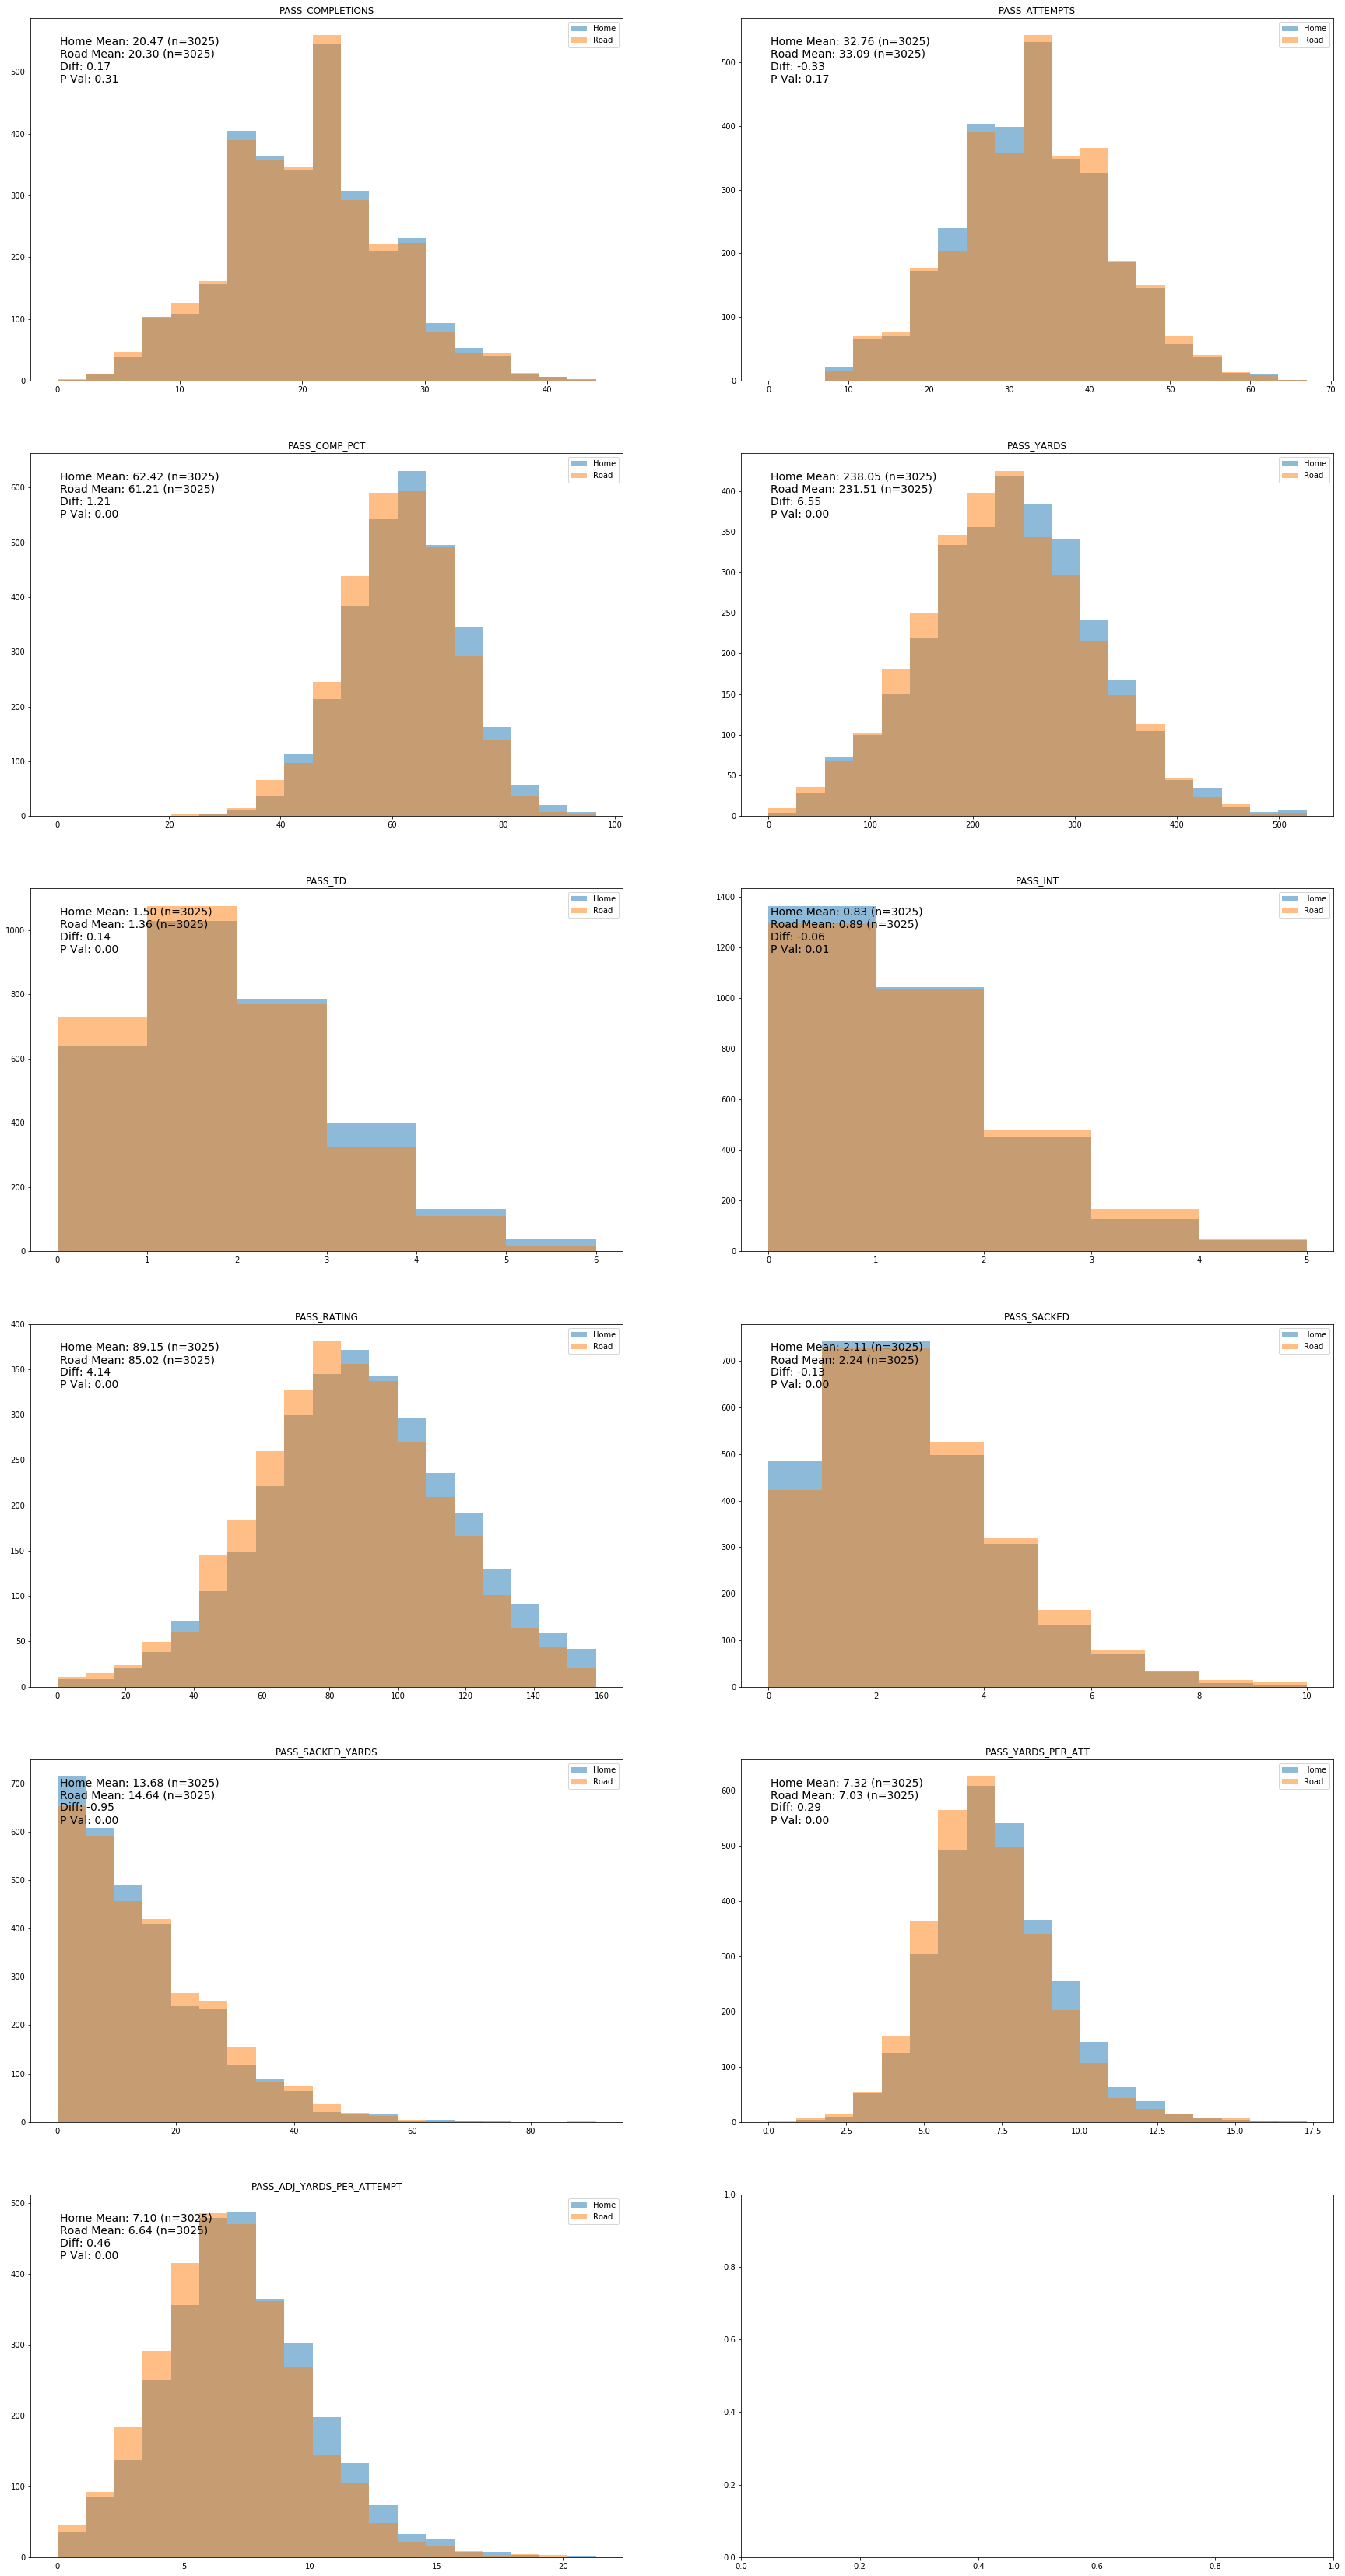

In [59]:
dt = 'passing'
kvd = get_key_value_dict(dt)
hg = get_home_games(kvd.copy(), dt)
rg = get_road_games(kvd.copy(), dt)
stat_dict = get_stat_dict(hg, rg, get_stat_ids(dt))
plot_stats(hg, rg, dt)

RUSH_ATTEMPTS
5 39
RUSH_YARDS
-14 286
RUSH_YARDS_PER_ATT
-2.4 22.13
RUSH_TD
0 4
FUMBLES
0.0 5.0


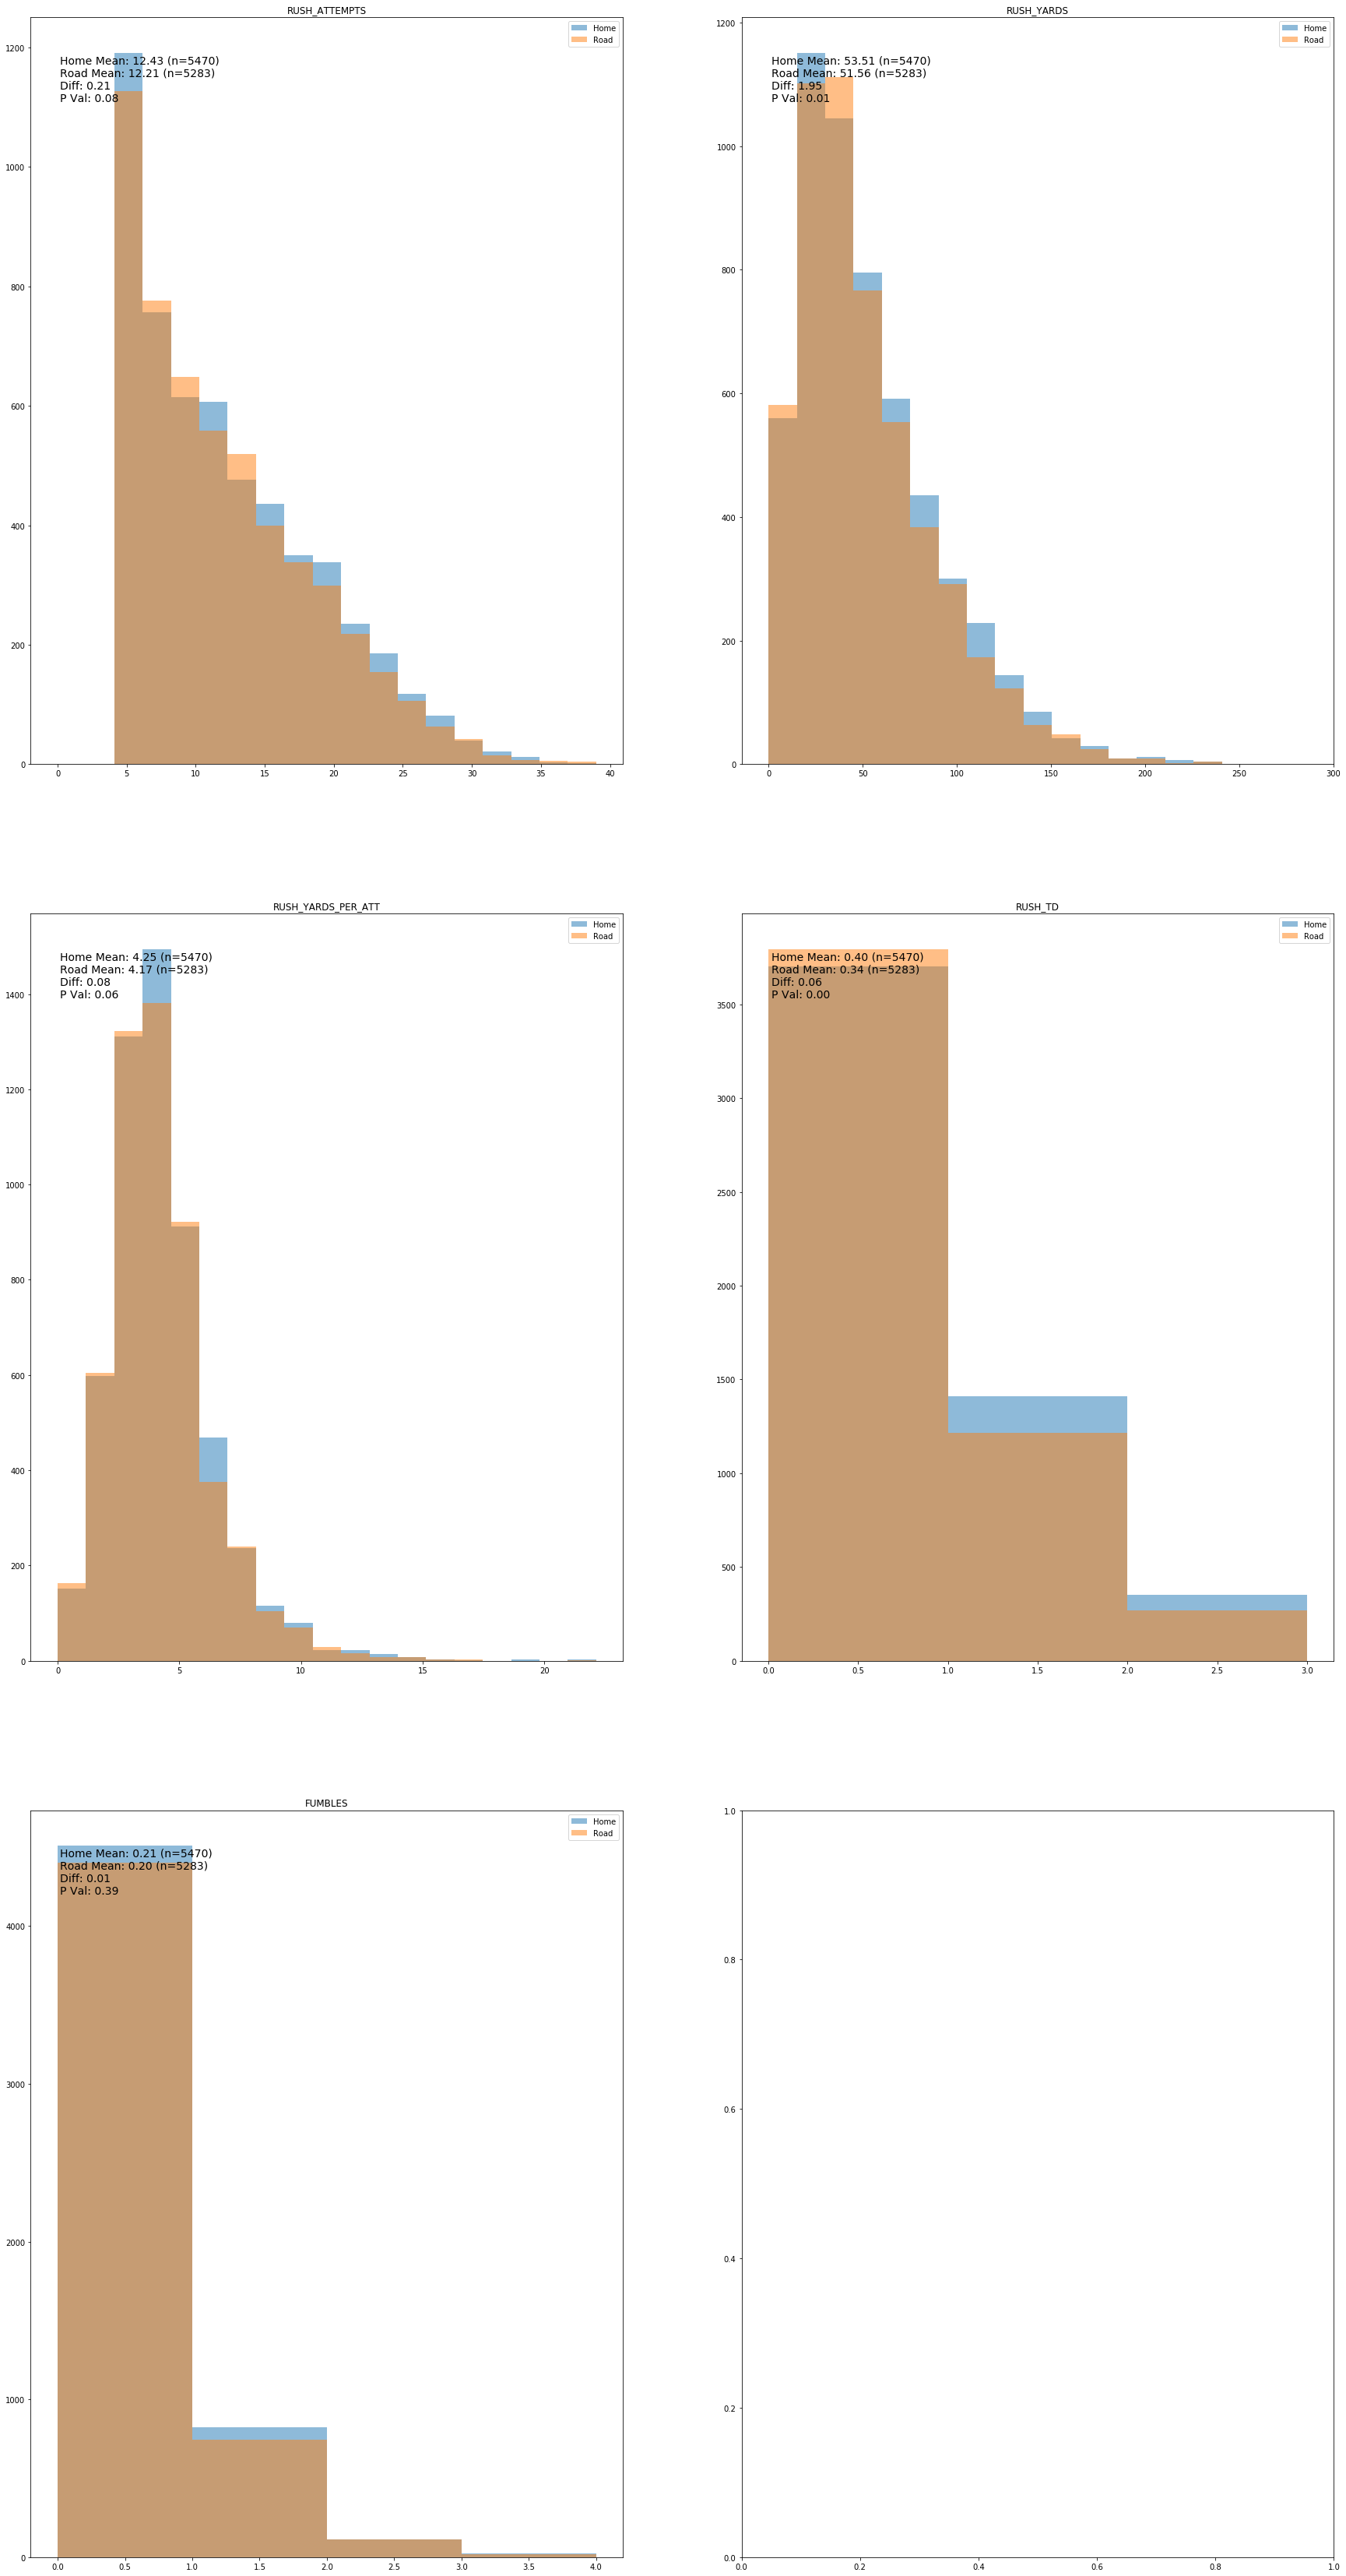

In [60]:
dt = 'rushing'
kvd = get_key_value_dict(dt)
hg = get_home_games(kvd.copy(), dt)
rg = get_road_games(kvd.copy(), dt)
stat_dict = get_stat_dict(hg, rg, get_stat_ids(dt))
plot_stats(hg, rg, dt)

In [61]:
dt = 'receiving'
kvd = get_key_value_dict(dt)
hg = get_home_games(kvd.copy(), dt)
rg = get_road_games(kvd.copy(), dt)
stat_dict = get_stat_dict(hg, rg, get_stat_ids(dt))
plot_stats(hg, rg, dt)

Exception: Stat is not numeric